In [1]:
# using Pkg
# Pkg.add("LinearAlgebra")
# Pkg.add("Statistics")
# Pkg.add("LsqFit")
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("IterTools")
# Pkg.add("DataStructures")
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("ForwardDiff")
# Pkg.add("OrderedCollections")
# Pkg.add("Dates")
# Pkg.add("Plots")
# Pkg.add("StatsPlots")
# Pkg.add("Distributions")
# Pkg.add("Random")
# Pkg.add("Optim")
# Pkg.add("Printf")
# Pkg.add("StatsBase")
# Pkg.add("LaTeXStrings")

In [2]:
using LinearAlgebra
using Statistics
using LsqFit
using CSV
using DataFrames
using Base.Iterators
using DataStructures
using JuMP
using Ipopt
using ForwardDiff
using OrderedCollections
using Dates
using Plots
using StatsPlots
using Distributions
using Random
using StatsBase
using LaTeXStrings 
using Optim
using Printf

In [3]:
const TRUE_KAPPA = 7.0
const TRUE_THETA = 0.13
const TRUE_SIGMA = 0.02

println("Feller Condition: ", 2*TRUE_KAPPA*TRUE_THETA - TRUE_SIGMA^2 )
println(" ")
println("Variance: ", TRUE_SIGMA^2)

Feller Condition: 1.8196
 
Variance: 0.0004


In [4]:
"""
    simulate_cir_paths(n_sim; ...)

Gera um (ou mais) caminho(s) do modelo CIR com os parâmetros verdadeiros.
"""
function simulate_cir_paths(r0::Float64, T::Float64, N::Int, n_sim::Int; kappa=TRUE_KAPPA, theta=TRUE_THETA, sigma=TRUE_SIGMA)
    # Simulation Parameters
    dt = T/N       # Time step size

    rates = zeros(N + 1, n_sim)
    rates[1, :] .= r0
    Z = rand(Normal(0, 1), N, n_sim)

    for t in 1:N
        sqrt_r_t = @. sqrt(max(0, rates[t, :]))
        rates[t+1, :] = @. rates[t, :] + kappa * (theta - rates[t, :]) * dt +
                         sigma * sqrt_r_t * sqrt(dt) * Z[t, :]
    end
    return rates, T, N, dt
end

simulate_cir_paths

In [5]:
"""
    ols_model(initial_guess, taxas) -> k, theta, r0_calibrated

Calibra kappa, theta e r0 usando LsqFit (ajuste de curva).
"""
function ols_model(initial_guess::Vector{Float64}, taxas::Vector{Float64})
    t_data = (0:length(taxas)-1) ./ (length(taxas)-1)

    # O modelo continua com 3 parâmetros: [kappa, theta, r0]
    model_fun(t, params) = @. params[2] + (params[3] - params[2]) * exp(-params[1] * t)
    
    # Limites para os 3 parâmetros
    lower = [0.0, 0.0, 0.0]
    upper = [Inf, Inf, Inf]
    
    # Agora usa o 'initial_guess' que foi passado como argumento
    fit = curve_fit(model_fun, t_data, taxas, initial_guess, lower=lower, upper=upper)
    k, theta, r0_calibrated = fit.param

    return k, theta, r0_calibrated
end

ols_model

In [6]:
"""
    estimate_sigma_squared(path, T, N, dt, r0, kappa, theta)

Estima sigma ao quadrado usando o método Z(t) com os kappa e theta já calibrados.
"""
function estimate_sigma_squared(path::Vector{Float64}, T::Float64, N::Int, dt::Float64, r0::Float64, kappa::Float64, theta::Float64)
    t_points = 0:dt:T
    num_points = N + 1
    
    # Usa os parâmetros calibrados para calcular r_bar, y, F
    r_bar = @. theta + (r0 - theta) * exp(-kappa * t_points)
    y = @. exp(kappa * t_points) * (path - r_bar)
    
    F_term_1 = @. (r0 - theta) * (exp(kappa * t_points) - 1)
    F_term_2 = @. (theta/2) * (exp(2*kappa * t_points) - 1)
    F = @. (F_term_1 + F_term_2) / kappa
    
    z_trajectory = zeros(num_points)
    
    for i in 2:num_points
        numerator = y[i]^2
        denominator = F[i] # F[1] é F(0), que é 0
        z_trajectory[i] = denominator > 1e-9 ? numerator / denominator : NaN
    end
    
    # A estimativa é a média dos Z(t) calculados ao longo do tempo
    return mean(filter(isfinite, z_trajectory))
end

estimate_sigma_squared

In [7]:
function calibrate_cir_mle(rates::Vector{Float64}, dt::Float64)
    """
    Calibra os parâmetros do CIR (κ, θ, σ) via Máxima Verossimilhança (MLE)
    usando a distribuição exata (Qui-Quadrado Não-Central).
    """
    
    function log_likelihood(params)
        kappa, theta, sigma = params[1], params[2], params[3]
        
        if kappa <= 0 || theta <= 0 || sigma <= 0 || 2 * kappa * theta < sigma^2
             return -Inf
        end

        total_loglik = 0.0
        for i in 2:length(rates)
            r_prev = rates[i-1]
            r_curr = rates[i]
            
            # Se a simulação produziu uma taxa negativa, ela está fora do domínio
            # da distribuição Qui-Quadrado. Penalizamos fortemente essa combinação
            if r_curr < 0
                return -Inf
            end

            # Passo 2 da Teoria: Calcular c, ν (dof), e λ (nc)
            c = 2 * kappa / (sigma^2 * (1 - exp(-kappa * dt)))
            dof = 4 * kappa * theta / sigma^2      # ν = graus de liberdade
            nc = 2 * c * r_prev * exp(-kappa * dt) # λ = parâmetro de não-centralidade
            
            dist = NoncentralChisq(dof, nc)
            scaled_variable = 2 * c * r_curr
            
            loglik_term = log(2c) + logpdf(dist, scaled_variable)
            
            if isinf(loglik_term) || isnan(loglik_term)
                return -Inf
            end
            total_loglik += loglik_term
        end
        return total_loglik
    end

    # O resto da função (objective_function, optimize, etc.) permanece o mesmo
    objective_function(params) = -log_likelihood(params)
    
    initial_guess = [0.5, 0.1, 0.1]
    lower_bounds = [1e-5, 1e-5, 1e-5]
    upper_bounds = [Inf, Inf, Inf]

    result = optimize(objective_function, lower_bounds, upper_bounds, initial_guess, Fminbox(BFGS()))
    
    if Optim.converged(result)
        return Optim.minimizer(result)
    else
        println("A otimização não convergiu.")
        return [NaN, NaN, NaN]
    end
end

calibrate_cir_mle (generic function with 1 method)

--- Passo 1: Gerando um caminho com parâmetros conhecidos ---
Caminho gerado com sucesso.

--- Método 1: Calibragem em Duas Etapas (com r0 calibrado) ---

--- Método 2: Máxima Verossimilhança (MLE) ---

--- Tabela Comparativa de Resultados ---
Parâmetro  | Valor Verdadeiro | Seu Método (Erro Rel.)    | MLE (Erro Rel.)          
--------------------------------------------------------------------------------
Kappa      | 7.0000           | 16.1880    (131.26%     ) | 8.7134     (24.48%      )
Theta      | 0.1300           | 0.1287     (1.03%       ) | 0.1298     (0.17%       )
Sigma      | 0.0200           | 0.0233     (16.39%      ) | 0.0203     (1.50%       )


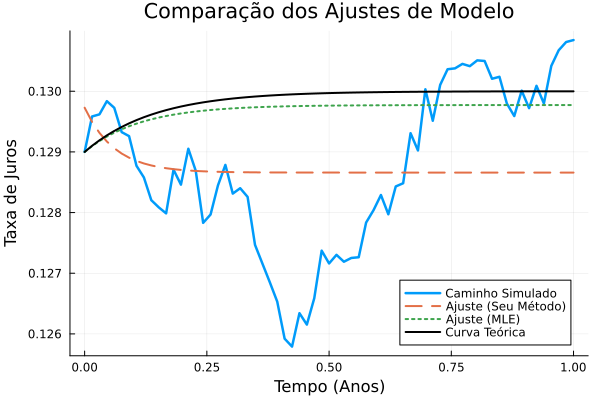

In [9]:
# --- BLOCO PRINCIPAL DE EXECUÇÃO -----

println("--- Passo 1: Gerando um caminho com parâmetros conhecidos ---")
paths, T, N, dt = simulate_cir_paths(0.129, 0.20, 66, 1)
simulated_path = vec(paths)
r0_real = simulated_path[1]
println("Caminho gerado com sucesso.\n")

# --- ANÁLISE COM O SEU MÉTODO ---
println("--- Método 1: Calibragem em Duas Etapas (com r0 calibrado) ---")
# Define o chute inicial aqui no bloco principal
initial_guess_ols = [7.0, 0.13, 0.2]
# Passa o chute inicial como argumento para a função
kappa_seu, theta_seu, r0_seu = ols_model(initial_guess_ols, simulated_path)
sigma_sq_seu = estimate_sigma_squared(simulated_path, T, N, dt, r0_seu, kappa_seu, theta_seu)
sigma_seu = sqrt(sigma_sq_seu)

# --- ANÁLISE COM MÁXIMA VEROSSIMILHANÇA ---
println("\n--- Método 2: Máxima Verossimilhança (MLE) ---")
kappa_mle, theta_mle, sigma_mle = calibrate_cir_mle(simulated_path, dt)

# --- COMPARAÇÃO FINAL ---
println("\n--- Tabela Comparativa de Resultados ---")
@printf "%-10s | %-16s | %-25s | %-25s\n" "Parâmetro" "Valor Verdadeiro" "Seu Método (Erro Rel.)" "MLE (Erro Rel.)"
println("-"^80)
err_k_seu_str = @sprintf "%.2f%%" 100*abs(kappa_seu - TRUE_KAPPA)/TRUE_KAPPA
err_k_mle_str = @sprintf "%.2f%%" 100*abs(kappa_mle - TRUE_KAPPA)/TRUE_KAPPA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Kappa" TRUE_KAPPA kappa_seu err_k_seu_str kappa_mle err_k_mle_str
err_t_seu_str = @sprintf "%.2f%%" 100*abs(theta_seu - TRUE_THETA)/TRUE_THETA
err_t_mle_str = @sprintf "%.2f%%" 100*abs(theta_mle - TRUE_THETA)/TRUE_THETA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Theta" TRUE_THETA theta_seu err_t_seu_str theta_mle err_t_mle_str
err_s_seu_str = @sprintf "%.2f%%" 100*abs(sigma_seu - TRUE_SIGMA)/TRUE_SIGMA
err_s_mle_str = @sprintf "%.2f%%" 100*abs(sigma_mle - TRUE_SIGMA)/TRUE_SIGMA
@printf "%-10s | %-16.4f | %-10.4f (%-12s) | %-10.4f (%-12s)\n" "Sigma" TRUE_SIGMA sigma_seu err_s_seu_str sigma_mle err_s_mle_str

# --- GRÁFICO COMPARATIVO DOS AJUSTES ---
t_plot = (0:N) ./ N
p = plot(t_plot, simulated_path, label="Caminho Simulado", title="Comparação dos Ajustes de Modelo", xlabel="Tempo (Anos)", ylabel="Taxa de Juros", linewidth=2.5, legend=:best)
plot!(p, t_plot, t -> theta_seu + (r0_seu - theta_seu) * exp(-kappa_seu * t), label="Ajuste (Seu Método)", linestyle=:dash, linewidth=2)
plot!(p, t_plot, t -> theta_mle + (simulated_path[1] - theta_mle) * exp(-kappa_mle * t), label="Ajuste (MLE)", linestyle=:dot, linewidth=2)
plot!(p, t_plot, t -> TRUE_THETA + (r0_real - TRUE_THETA) * exp(-TRUE_KAPPA * t), label="Curva Teórica", linestyle=:solid, color=:black, linewidth=2)
display(p)